##### 1. Introduction
This notebook focuses on predicting real estate prices in Maricopa County, AZ. We will first use traditional machine learning, followed by a deep learning approach, to understand the nuances and performances of each.

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
import tensorflow as tf
from tensorflow import keras

##### 2. Data Loading, Preprocessing, Exploration


C:\Users\banja\AppData\Local\Temp\ipykernel_34920\3898583979.py:3: DtypeWarning: Columns (22) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data/MaricopaCounty_SampleTransactions_2020_2023.csv')


(51325, 29)


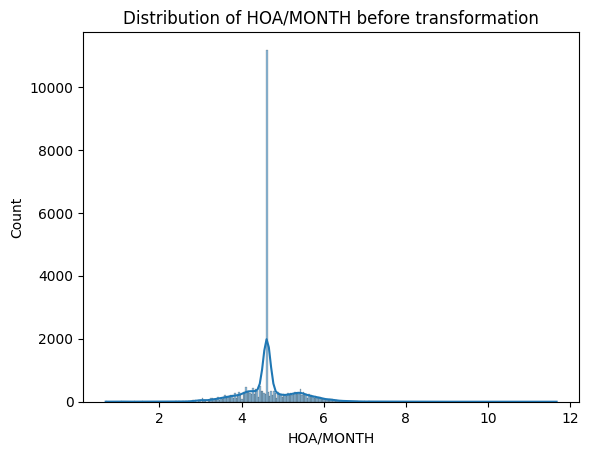

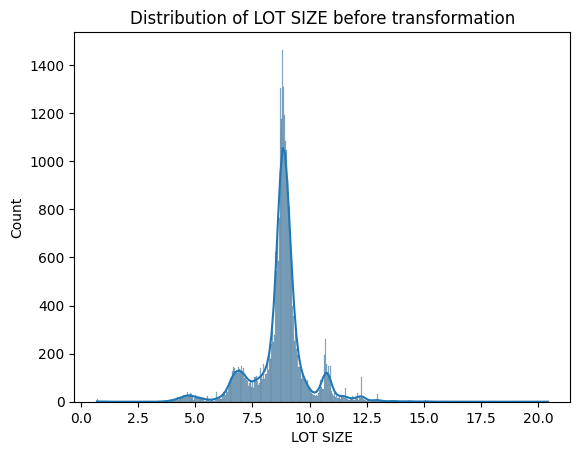

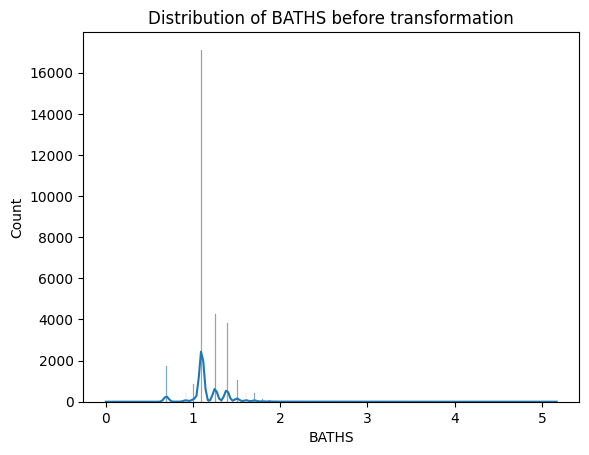

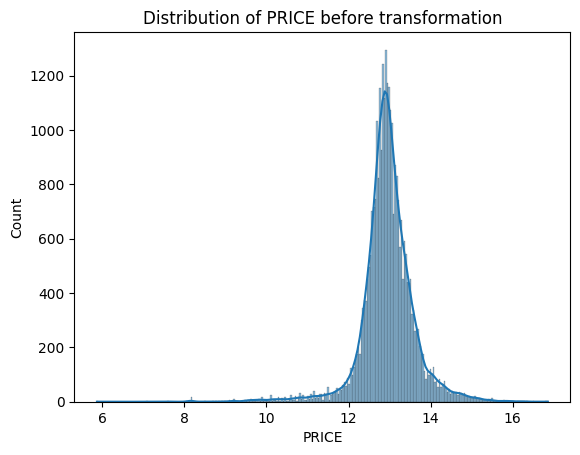

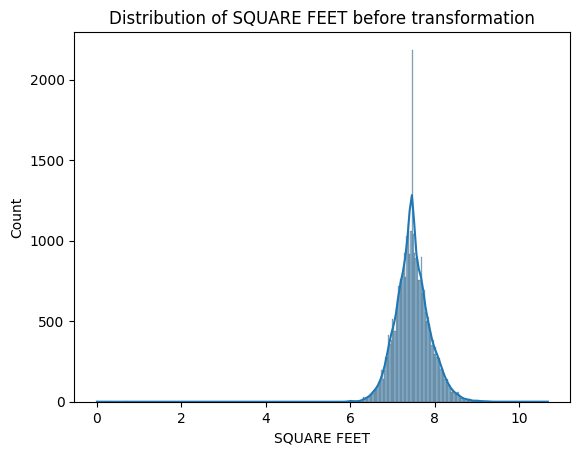

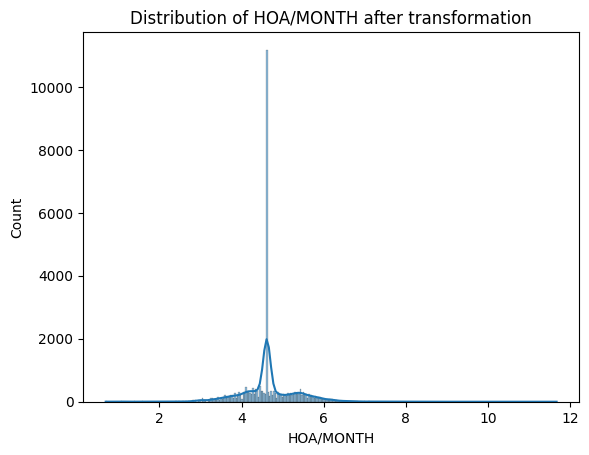

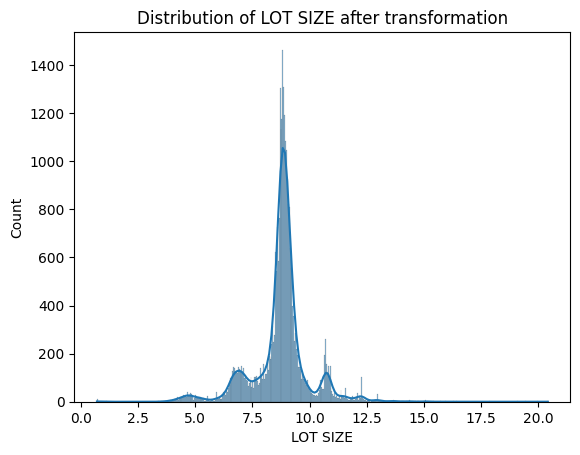

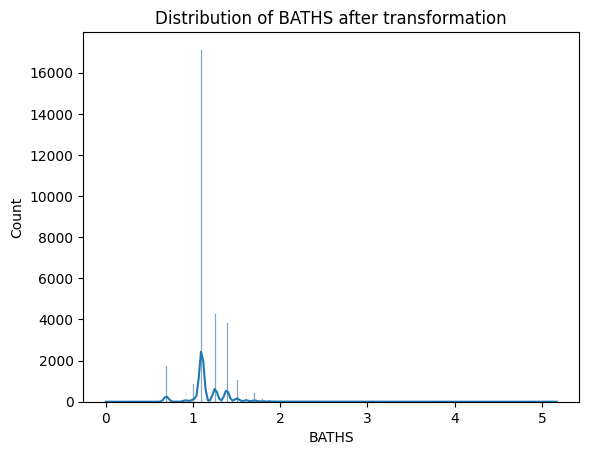

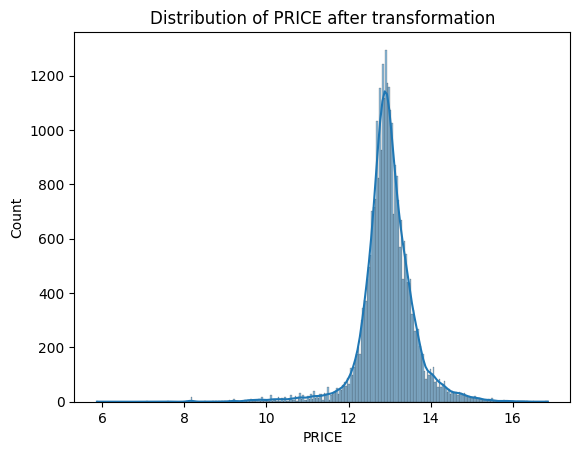

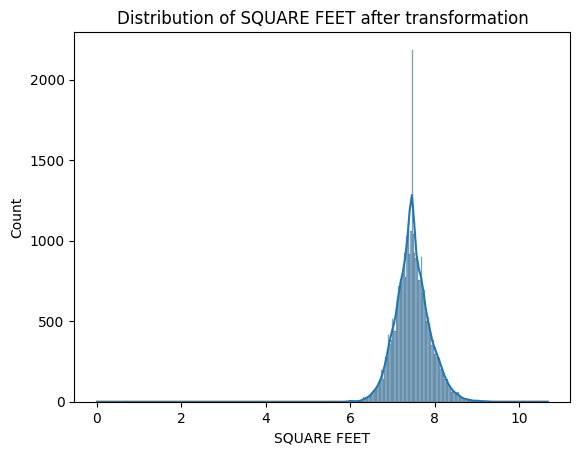

BATHS                  1.454248
BEDS                   0.634905
HOA/MONTH              0.075822
LATITUDE              -0.019203
LOT SIZE              -0.235573
SQUARE FEET           -0.352653
LONGITUDE             -0.539292
YEAR BUILT            -0.643960
PRICE                 -0.821127
ZIP OR POSTAL CODE   -75.742938
dtype: float64


In [19]:
# LOAD
#----------------------------

df = pd.read_csv('data/MaricopaCounty_SampleTransactions_2020_2023.csv')
df = df.dropna(subset=['SOLD DATE'])
df['SOLD DATE'] = pd.to_datetime(df['SOLD DATE'])
df['SALE_YEAR'] = df['SOLD DATE'].dt.year
df['SALE_MONTH'] = df['SOLD DATE'].dt.month

print(df.shape) #51k records 


# PREPROCESSING
#----------------------------

# retaining only the valuable columns
drop_columns = ["SALE TYPE", "ADDRESS", "STATE OR PROVINCE", "SOLD DATE", "DAYS ON MARKET",
                "$/SQUARE FEET", "STATUS", "NEXT OPEN HOUSE START TIME", 
                "NEXT OPEN HOUSE END TIME", 
                "URL (SEE https://www.redfin.com/buy-a-home/comparative-market-analysis FOR INFO ON PRICING)", 
                "SOURCE", "MLS#", "FAVORITE", "INTERESTED"]
df = df.drop(columns=drop_columns)

# numeric, fill with median 
for col in df.select_dtypes(include=['float64', 'int64']).columns:
    df[col].fillna(df[col].median(), inplace=True)

# categorical, fill with mode 
for col in df.select_dtypes(exclude=['float64', 'int64']).columns:
    mode_value = df[col].mode()
    if not mode_value.empty:
        df[col].fillna(mode_value.iloc[0], inplace=True)

# one-hot encode, easier for ML 
df = pd.get_dummies(df, columns=["PROPERTY TYPE", "LOCATION"], drop_first=True)


# EXPLORATION
#----------------------------

# data exploration: visualizing skewness for numeric features before transformation
features_to_plot = ['HOA/MONTH', 'LOT SIZE', 'BATHS', 'PRICE', 'SQUARE FEET']
for feature in features_to_plot:
    sns.histplot(train_df[feature], kde=True)
    plt.title(f'Distribution of {feature} before transformation')
    plt.show()

# split data into training, validation, and test sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.25, random_state=42)  # 0.25 * 0.8 = 0.2

#skewed_features = train_df.select_dtypes(include=['float64', 'int64']).apply(lambda x: x.skew()).sort_values(ascending=False)
#print(skewed_features)

# apply log1p transformation for positively skewed features
positively_skewed = ['HOA/MONTH', 'LOT SIZE', 'BATHS', 'PRICE', 'SQUARE FEET']
for feature in positively_skewed:
    train_df[feature] = np.log1p(train_df[feature])
    val_df[feature] = np.log1p(val_df[feature])
    test_df[feature] = np.log1p(test_df[feature])

# visualize distributions after transformations
for feature in features_to_plot:
    sns.histplot(train_df[feature], kde=True)
    plt.title(f'Distribution of {feature} after transformation')
    plt.show()

# apply cube transformation for negatively skewed features
negatively_skewed = ['LONGITUDE', 'YEAR BUILT', 'ZIP OR POSTAL CODE']
for feature in negatively_skewed:
    train_df[feature] = train_df[feature]**3
    val_df[feature] = val_df[feature]**3
    test_df[feature] = test_df[feature]**3

# re-check skewness after transformations
new_skewed_features = train_df.select_dtypes(include=['float64', 'int64']).apply(lambda x: x.skew()).sort_values(ascending=False)
print(new_skewed_features)

X_train = train_df.drop(columns=["PRICE"])
y_train = train_df["PRICE"]

X_val = val_df.drop(columns=["PRICE"])
y_val = val_df["PRICE"]

X_test = test_df.drop(columns=["PRICE"])
y_test = test_df["PRICE"]

3. Traditional Machine Learning Implementation (e.g., Linear Regression)


In [17]:
pd.set_option('display.max_rows', None)
columns_with_nan = X_train.columns[X_train.isnull().any()].tolist()
print(columns_with_nan)



# initialize the Linear Regression model
lr = LinearRegression()

# train the model using the training data
lr.fit(X_train, y_train)

# predict on validation set and compute metrics
y_pred_val = lr.predict(X_val)
mae_val = mean_absolute_error(y_val, y_pred_val)
mse_val = mean_squared_error(y_val, y_pred_val)
print(f"validation MAE for Linear Regression: {mae_val}")
print(f"validation MSE for Linear Regression: {mse_val}")

# predict on test set and compute metrics
y_pred_test = lr.predict(X_test)
mae_test = mean_absolute_error(y_test, y_pred_test)
mse_test = mean_squared_error(y_test, y_pred_test)
print(f"test MAE for Linear Regression: {mae_test}")
print(f"test MSE for Linear Regression: {mse_test}")



[]


ValueError: could not convert string to float: 'Mesa'

4. Neural Network Implementation using Keras & TensorFlow


In [ ]:
# design the neural network architecture
model = keras.Sequential([
    keras.layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(1)
])

# compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# train the model using the training data
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val), verbose=0)

# evaluate the model on the validation and test sets
val_loss, val_mae = model.evaluate(X_val, y_val, verbose=0)
test_loss, test_mae = model.evaluate(X_test, y_test, verbose=0)
print(f"validation MAE for Neural Network: {val_mae}")
print(f"test MAE for Neural Network: {test_mae}")

